### Some notes and feedbacks of the project
* Before making a prediction, a trend was observed using a weekly ohlc chart 
* Linear regression has been used to make a price prediction
* Approach: Created a new column 'Prediciton' and trained the linear regression model using shift to forecast the price
* While the implementation is very straightforward, its accuracy is difficult to justify
* I've figured a more sophisticated model like ARIMA would have been more suitable given such volatility of stock prices

In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing, model_selection
from sklearn.linear_model import LinearRegression
from matplotlib import pyplot as plt
import pickle
import mplfinance as mpf
from mplfinance.original_flavor import candlestick_ohlc
import matplotlib.dates as mdates
from matplotlib.dates import date2num
import datetime as dt
from matplotlib import style

style.use('ggplot')
plt.rcParams['figure.figsize'] = [16, 8]

In [2]:
df = pd.read_csv(r'C:\Users\taewoo\Desktop\Datasets\GOOG.csv', index_col='Date')
df.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-08-19,1553.310059,1573.680054,1543.949951,1547.530029,1547.530029,1660600
2020-08-20,1543.449951,1585.869995,1538.199951,1581.750000,1581.750000,1706900
2020-08-21,1577.030029,1597.719971,1568.005005,1580.420044,1580.420044,1446500
2020-08-24,1593.979980,1614.170044,1580.569946,1588.199951,1588.199951,1409900
2020-08-25,1582.069946,1611.619995,1582.069946,1608.219971,1608.219971,2247100


In [3]:
df.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

There is no missing value

In [4]:
print(df['Close'].equals(df['Adj Close']))

True


Given Adj Close and Close columns are identical, it would be okay to drop the Adj Close column for this analysis

In [5]:
df.drop(columns='Adj Close', inplace=True)

Before making a prediction, I want to see the trend in the past by investigating the ohlc chart of Google stocks

### Candlestick graphs of weekly ohlc 

In [6]:
df.index = pd.to_datetime(df.index)
# resampling data: find weekly OHLC (Open, High, Low, Close)
df_weekly = df.resample('7D').agg({'Open':'first', 'High':'max', 'Low':'min', 'Close':'last', 'Volume':'sum'})
df_weekly.reset_index(inplace=True)
df_volume = df[['Volume']].resample('7D').sum()
df_volume.reset_index(inplace=True)
# date -> matplotlib format of date
df_weekly['Date'] = df_weekly['Date'].map(mdates.date2num)
df_volume['Date'] = df_volume['Date'].map(mdates.date2num)
print(df_weekly.head())
print(df_volume.head())

      Date        Open        High         Low       Close    Volume
0  16804.0  743.000000  752.000000  713.000000  714.469971  12585100
1  16811.0  716.609985  734.739990  685.369995  694.450012  12450700
2  16818.0  703.299988  728.130005  673.260010  725.250000  10137100
3  16825.0  723.580017  744.989990  694.390015  742.950012  11388300
4  16832.0  750.460022  789.869995  680.150024  683.570007  27932700
      Date    Volume
0  16804.0  12585100
1  16811.0  12450700
2  16818.0  10137100
3  16825.0  11388300
4  16832.0  27932700


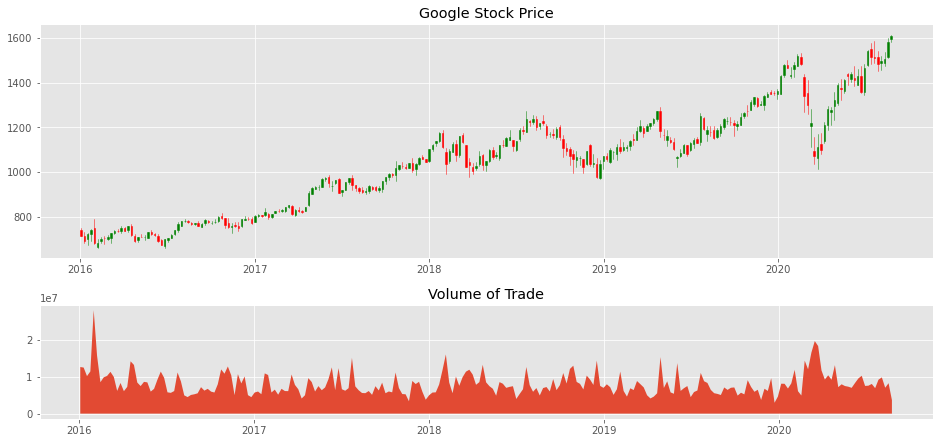

In [7]:
ax1 = plt.subplot2grid((11,1), (0,0), rowspan=6, colspan=1)
ax2 = plt.subplot2grid((11,1), (7,0), rowspan=3, colspan=1)
ax1.xaxis_date()
ax2.xaxis_date()
candlestick_ohlc(ax1, df_weekly.values, width=3, colorup='g')
ax1.set_title('Google Stock Price')
ax2.fill_between(df_volume['Date'], df_volume['Volume'])
ax2.set_title('Volume of Trade')
plt.show()

The price of Google stock since 2016 to 2020 shows a **positively sloped** trend line. 

### Building a model to make a prediction

In [8]:
# to see the percentage change in stock prices
df['Pct_Change'] = (df['Close'] - df['Open']) / df['Open']*100

In [9]:
df_copy = df.copy()[['Open', 'High', 'Low', 'Close', 'Pct_Change']]

In [10]:
# Forecast 7 days into the future
forecast_col = 'Close'
forecast_out = 7
df_copy['Prediction'] = df[forecast_col].shift(-forecast_out)
print(df_copy.tail(10))

                   Open         High          Low        Close  Pct_Change  \
Date                                                                         
2020-08-12  1485.579956  1512.385986  1485.250000  1506.619995    1.416285   
2020-08-13  1510.339966  1537.250000  1508.005005  1518.449951    0.536964   
2020-08-14  1515.660034  1521.900024  1502.880005  1507.729980   -0.523208   
2020-08-17  1514.670044  1525.609985  1507.969971  1517.979980    0.218525   
2020-08-18  1526.180054  1562.469971  1523.709961  1558.599976    2.124253   
2020-08-19  1553.310059  1573.680054  1543.949951  1547.530029   -0.372111   
2020-08-20  1543.449951  1585.869995  1538.199951  1581.750000    2.481457   
2020-08-21  1577.030029  1597.719971  1568.005005  1580.420044    0.214962   
2020-08-24  1593.979980  1614.170044  1580.569946  1588.199951   -0.362616   
2020-08-25  1582.069946  1611.619995  1582.069946  1608.219971    1.652899   

             Prediction  
Date                     
2020-08-12 

Notice the last few lines of Prediction column are NaN, this is because I am training the model to predict 7 days into the future with `shift`.

In [11]:
# X is features to predict y, y is the price of Google stocks in the future
X = np.array(df_copy.drop(['Prediction'], 1))
X = preprocessing.scale(X)
X_recent = X[-forecast_out:]
X = X[:-forecast_out]

y = np.array(df_copy['Prediction'])
y = y[:-forecast_out]

I am ready to start training.

Due to the test sizing process, the model is going to return a different result every time, so let's run it 800 times to get the model with best accuracy. Then, I can create a pickle file and store the model, so I can use it later.

In [12]:
best = 0
for __ in range(800):
    x_train, x_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2)
    linear = LinearRegression()
    linear.fit(X,y)
    accuracy = linear.score(x_test, y_test)
    if accuracy > best:
        best = accuracy
        with open("google_regression.pickle", "wb") as f:
            pickle.dump(linear, f)

pickle_in = open("google_regression.pickle", "rb")
linear = pickle.load(pickle_in)
print(f'Accuracy:{best}')

Accuracy:0.9781825231200292


In [13]:
forecast = linear.predict(X_recent)
print(forecast)

[1519.33674848 1556.3890676  1554.07499549 1578.04423897 1583.33471574
 1593.39216972 1606.74008463]


These are the predicted prices of Google stocks for the **next 7 days**

In [14]:
print(df)

                   Open         High          Low        Close   Volume  \
Date                                                                      
2016-01-04   743.000000   744.059998   731.257996   741.840027  3272800   
2016-01-05   746.450012   752.000000   738.640015   742.580017  1950700   
2016-01-06   730.000000   747.179993   728.919983   743.619995  1947000   
2016-01-07   730.309998   738.500000   719.059998   726.390015  2963700   
2016-01-08   731.450012   733.229980   713.000000   714.469971  2450900   
...                 ...          ...          ...          ...      ...   
2020-08-19  1553.310059  1573.680054  1543.949951  1547.530029  1660600   
2020-08-20  1543.449951  1585.869995  1538.199951  1581.750000  1706900   
2020-08-21  1577.030029  1597.719971  1568.005005  1580.420044  1446500   
2020-08-24  1593.979980  1614.170044  1580.569946  1588.199951  1409900   
2020-08-25  1582.069946  1611.619995  1582.069946  1608.219971  2247100   

            Pct_Change  

In [15]:
# Now that I got predicted values, let's plot the data 
df.reset_index(level=0, inplace=True)
df = df[['Date', 'Close']]

df['Date'] = pd.to_datetime(df['Date'])
forecast_date = pd.date_range('2020-08-26', periods=forecast_out, freq='D')
predict_df = pd.DataFrame({'Date':forecast_date, "Close":forecast})
# put dataframes into one
df = df.append(predict_df)
df.reset_index(inplace=True, drop=True)
print(f'Original Table \n{df.tail(10)}')

Original Table 
           Date        Close
1167 2020-08-21  1580.420044
1168 2020-08-24  1588.199951
1169 2020-08-25  1608.219971
1170 2020-08-26  1519.336748
1171 2020-08-27  1556.389068
1172 2020-08-28  1554.074995
1173 2020-08-29  1578.044239
1174 2020-08-30  1583.334716
1175 2020-08-31  1593.392170
1176 2020-09-01  1606.740085


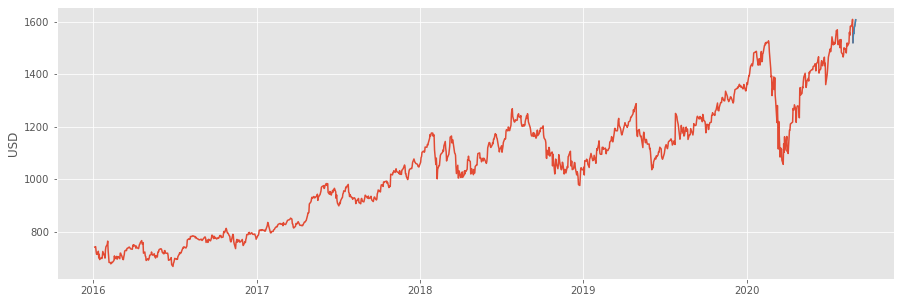

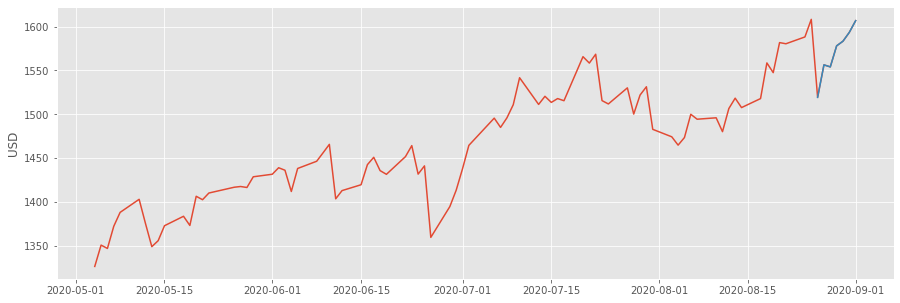

In [16]:
plt.rcParams['figure.figsize'] = [15, 5]
forecast_df = df.loc[df['Date'] > '20200501']
plt.plot('Date', 'Close', data=df)
plt.plot('Date', 'Close', data=predict_df)
plt.ylabel('USD')
plt.show()
plt.plot('Date', 'Close', data=forecast_df)
plt.plot('Date', 'Close', data=predict_df)
plt.ylabel('USD')
plt.show()

Based on the linear regression model, Google stock prices are expected to increase to the maximum of `$1606.740085`